# Neural Architecture Search for Large Language Models


This notebook shows how to use neural architecture search (NAS) to compress a large language model fine-tuned on some target task.
The goal is to reduce model size while retaining performance as much as possible. For that, we search for parts of the network (sub-networks), that jointly optimize parameter count and validation error.
There are different ways to define sub-networks. Here, we consider subsets of multi-head attention and fully-connected layers.

More specifically, our NAS approach consists of two steps:
- We first fine-tune the pre-trained model on the target task, by weight-sharing based NAS training strategies. The idea is to treat the pre-trained model as a 'super-network' that contains a large, but finite set of sub-networks. To avoid that sub-networks co-adapt we modify the fine-tuning the super-network by only updated parts of the network (i.e subset of all layers) in each iteration.
- In the second step, we use multi-objective search to find a set of sub-networks that optimally trade-off between parameter count and validation error on the target task.

At the end we can plot the so-called Pareto set of architecture and select the final model that gives us the right trade-off between model size and validation error.


**Limitations**

- So far we only support the BERT and GPT2 model family
- For now we use Syne Tune for the multi-objective search. In the future we will use AMT, which allows us to distribute the search across multiple SageMaker training jobs


## Install requirements

Before we get started, we have to install all requirements

In [ ]:
!pip install -r requirements.txt

## Imports

In [1]:
import logging
import numpy as np
import evaluate
import torch

from datasets import load_dataset
from torch.utils.data import DataLoader, Subset

from transformers import (
    AutoTokenizer,
    default_data_collator,
    TrainingArguments,
    AutoModelForSequenceClassification,
    AutoConfig
)

from training import train_supernetwork
from search import multi_objective_search
from parse_model import get_final_model

logger = logging.getLogger(__name__)

## Hyperparameters

We define different hyperparameters for our model and dataset.

In [2]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

task_name = 'rte'
model_type = 'bert-base-cased'
output_dir = 'nas_output_dir'
max_seq_length = 128
per_device_train_batch_size = 8
per_device_eval_batch_size = 8
seed = 42

## Load Dataset and Evaluation Metric

We load the RTE dataset from the GLUE benchmarking suite via the dataset library from HuggingFace 

In [3]:
raw_datasets = load_dataset(
    "glue", task_name
)

metric = evaluate.load("glue", task_name)

  0%|          | 0/3 [00:00<?, ?it/s]

## Data Preprocessing

This follows the standard Huggingface code from this example: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py


In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_type)

if model_type.startswith("gpt2"):
    tokenizer.pad_token = tokenizer.eos_token

# Preprocessing the raw_datasets
sentence1_key, sentence2_key = task_to_keys[task_name]

# Padding strategy
padding = "max_length"

max_seq_length = min(max_seq_length, tokenizer.model_max_length)

def preprocess_function(examples):
    # Tokenize the texts
    args = (
        (examples[sentence1_key],)
        if sentence2_key is None
        else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(
        *args, padding=padding, max_length=max_seq_length, truncation=True
    )

    return result

raw_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    desc="Running tokenizer on dataset",
)

label_list = raw_datasets["train"].features["label"].names
num_labels = len(label_list)

Running tokenizer on dataset:   0%|          | 0/3000 [00:00<?, ? examples/s]

## Split Dataset in Training / Validation

We need an extra validation set to evaluate different sub-networks during the multi-objective search. We split the training dataset from GLUE into a extra training / validation set.

In [5]:
train_dataset = raw_datasets["train"]
test_dataset = raw_datasets[
    "validation_matched" if task_name == "mnli" else "validation"
]

train_dataset = train_dataset.remove_columns(["idx"])
test_dataset = test_dataset.remove_columns(["idx"])

split = train_dataset.train_test_split(
    train_size=0.7, seed=0
)  # fix seed to make results reproducible
valid_dataset = split["test"]


data_collator = default_data_collator

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=per_device_train_batch_size,
    collate_fn=data_collator,
)
eval_dataloader = DataLoader(
    valid_dataset,
    batch_size=per_device_eval_batch_size,
    collate_fn=data_collator,
)

## Load pre-trained Model

In [6]:
config = AutoConfig.from_pretrained(
    model_type,
    num_labels=num_labels,
    finetuning_task=task_name,
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_type,
    config=config,
)


if model_type.startswith("gpt2"):
    model.config.pad_token_id = model.config.eos_token_id

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

## Train weight-sharing based Super-Network

We now fine-tune our pre-training network, i.e super-network. To control the training we can use the TrainingArguments of the HuggingFace transformer library. We can pass additional arguments to specify if our dataset is regression or not (determines the loss function)

In [7]:
training_args = TrainingArguments(output_dir=output_dir)
training_args.use_accelerate = False # set this to True to distribute training on multiple GPUs
training_args.is_regression = False  # set this to True if your dataset is a regression dataset, for example STSB
training_args.save_strategy = "epoch"
training_args.log_dir = '.log_dir'
training_args.seed = seed
train_supernetwork(model, train_dataloader, eval_dataloader, metric, training_args)

  0%|          | 0/936 [00:00<?, ?it/s]

## Multi-objective search for sub-networks

After fine-tuning, we run multi-objective search by sampling random sub-networks. Compared to single-objective optimization, in the multi-objective setting we usually do not have a single solution that jointly optimizes all objectives. Instead, we collect a set of solution that *dominate* all other solutions at least in one objective.

In [8]:
metric_name = 'accuracy'
training_args.num_samples = 50
pareto_set = multi_objective_search(model, eval_dataloader, metric, metric_name, training_args)

## Visualize Results

Let's plot the Pareto set - the set of final sub-networks - and compare it against the un-pruned network. 

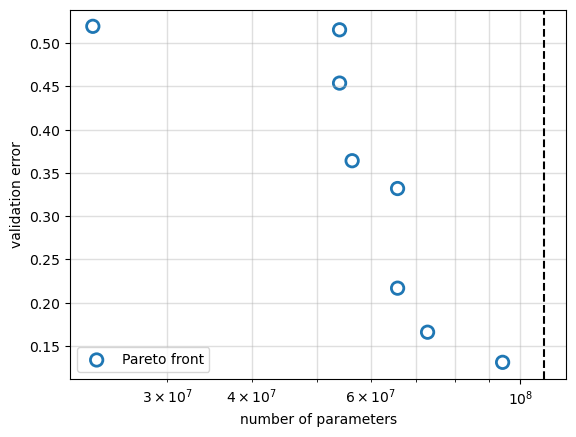

In [9]:
import matplotlib.pyplot as plt

n_params_original_model = sum(
            p.numel() for p in model.parameters() if p.requires_grad
        )
plt.axvline(n_params_original_model, color='black', linestyle='--')

plt.scatter(pareto_set['params'], pareto_set['error'], marker='o', s=80,
            facecolors='none', edgecolors='C0', linewidth=2, label='Pareto front')
plt.xlabel('number of parameters')
plt.ylabel('validation error')
plt.legend()
plt.xscale('log')
plt.grid(linewidth='1', alpha=0.4, which="both")

## Select Final Model

Finally, we can select the model from the Pareto set that gives us the right balance between parameter count and validation error

In [10]:
architecture_definition = pareto_set['configs'][0]
new_model = get_final_model(original_model=model, architecture_definition=architecture_definition)

n_params_new_model = sum(
            p.numel() for p in new_model.parameters() if p.requires_grad
        )